In [61]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from PIL import Image

import tensorflow as tf

keras = tf.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# https://github.com/tensorflow/tensorflow/issues/24828
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [78]:
DF_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/'
IMAGES_PATH = '/data/Documents/coverTheBookLover/data/goodreads-best-books/images/images/'

IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_CHANNELS = 3

VAL_SIZE = 0.2
MAX_POOL_DIM = 2
KERNEL_SIZE = 3

batch_size = 64

# How to get reproducible results in keras-StackOverflow
# Seed value
# Apparently you may use different seed values at each stage
RANDOM_STATE = 22

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(RANDOM_STATE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(RANDOM_STATE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(RANDOM_STATE)

# 5. Image number to filepath
def get_image(file_name, 
              root = IMAGES_PATH, 
              extension = '.jpg', 
              resize = False,
              reduce_channels = False):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
#     filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, str(file_name) + extension)
    img = Image.open(file_path)
    if resize == True:
        img = img.resize((IMAGE_WIDTH,IMAGE_HEIGHT))
#     img = skimage.transform.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), 
#                                      mode='reflect')
    if reduce_channels == True:
        return np.array(img)[:,:,:IMAGE_CHANNELS]
    else:
        return np.array(img)

In [38]:
# A bit of exploring on the dataframe
books_df = pd.read_csv(DF_PATH + 'book_data.csv')

# image filename is connected to initial index in dataframe 
books_df['img_name'] = books_df.index
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54301 entries, 0 to 54300
Data columns (total 13 columns):
book_authors         54301 non-null object
book_desc            52970 non-null object
book_edition         5453 non-null object
book_format          52645 non-null object
book_isbn            41435 non-null object
book_pages           51779 non-null object
book_rating          54301 non-null float64
book_rating_count    54301 non-null int64
book_review_count    54301 non-null int64
book_title           54301 non-null object
genres               51059 non-null object
image_url            53618 non-null object
img_name             54301 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.4+ MB


In [39]:
books_df.head(10)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...,0
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,1
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,2
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...,3
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...,4
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...,5
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...,6
7,George Orwell,مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.....,NaN,Paperback,9.78045E+12,122 pages,3.90,2235084,42156,Animal Farm,Classics|Fiction|Science Fiction|Dystopia|Fant...,https://images.gr-assets.com/books/1424037542l...,7
8,Margaret Mitchell,Gone with the Wind is a novel written by Marga...,NaN,Paperback,9.78045E+12,1037 pages,4.29,969181,17452,Gone with the Wind,Classics|Historical|Historical Fiction|Fiction...,https://images.gr-assets.com/books/1328025229l...,8
9,J.R.R. Tolkien,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Hobbit Movie Tie-in Boxed set,Mass Market Paperback,9.78035E+12,1728 pages,4.59,99793,1652,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Fantasy|Fiction|Classics,https://images.gr-assets.com/books/1346072396l...,9


### Ratings

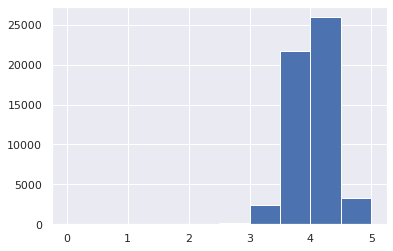

In [54]:
books_df['book_rating'].hist()

Most of the ratings are within 3 and 5 range

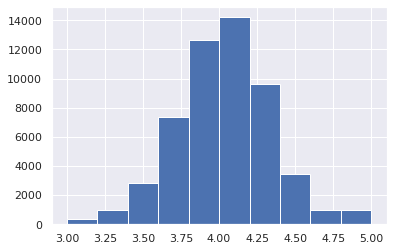

In [55]:
books_df[books_df['book_rating'] >= 3]['book_rating'].hist()

### Images

In [40]:
image_files = list(os.listdir(IMAGES_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 53618


In [41]:
random_check = books_df.sample(1, random_state = RANDOM_STATE).iloc[0]['img_name']
books_df.sample(1, random_state = RANDOM_STATE)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name
38575,Patricia Briggs,Tensions between the fae and humans are coming...,NaN,Hardcover,9.78043E+12,342 pages,4.37,29807,2640,Fire Touched,Fantasy|Urban Fantasy|Fantasy|Fantasy|Paranorm...,https://images.gr-assets.com/books/1441912000l...,38575


The image size is: (315, 475)


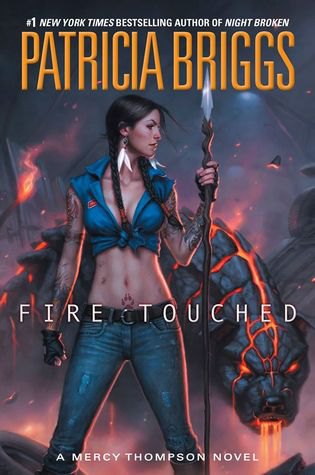

In [42]:
# Open the image
img = Image.open(IMAGES_PATH + str(random_check) + '.jpg') 

# Get the image size
print("The image size is: {}".format(img.size))

# Just having the image as the last line in the cell will display it in the notebook
img

In [44]:
# Check if the ID matches the book
print(IMAGES_PATH + str(random_check) + '.jpg') 

/data/Documents/coverTheBookLover/data/goodreads-best-books/images/images/38575.jpg


Check if all image names match their rows

In [46]:
file_names = list(books_df['img_name'].apply(lambda row: str(row) + '.jpg'))
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))
print('Total image names: ', len(books_df))

Matching image names: 53618
Total image names:  54301


Check for missing:

In [47]:
books_df['image_url'].notnull().value_counts()

True     53618
False      683
Name: image_url, dtype: int64

In [48]:
# save this one for modelling
books_df = books_df[books_df['image_url'].notnull()].reset_index(drop = True)
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53618 entries, 0 to 53617
Data columns (total 13 columns):
book_authors         53618 non-null object
book_desc            52536 non-null object
book_edition         5423 non-null object
book_format          52201 non-null object
book_isbn            41024 non-null object
book_pages           51391 non-null object
book_rating          53618 non-null float64
book_rating_count    53618 non-null int64
book_review_count    53618 non-null int64
book_title           53618 non-null object
genres               50679 non-null object
image_url            53618 non-null object
img_name             53618 non-null int64
dtypes: float64(1), int64(3), object(9)
memory usage: 5.3+ MB


In [49]:
books_df.head()

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...,0
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,1
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,2
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...,3
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...,4


In [50]:
random_check = books_df.sample(1, random_state = RANDOM_STATE).iloc[0]['img_name']
books_df.sample(1, random_state = RANDOM_STATE)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name
40719,Katherine Applegate,Most of us probably won't get the chance to ...,NaN,Paperback,9.78059E+12,176 pages,3.94,1898,34,Gateway to the Gods,Fantasy|Young Adult|Fantasy|Mythology|Fiction,https://images.gr-assets.com/books/1322353364l...,41176


The image size is: (166, 280)


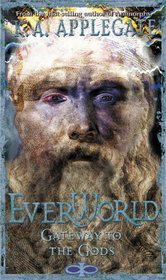

In [51]:
# Open the image
img = Image.open(IMAGES_PATH + str(random_check) + '.jpg') 

# Get the image size
print("The image size is: {}".format(img.size))

# Just having the image as the last line in the cell will display it in the notebook
img

In [57]:
# There is an error with couple images. Removing from analysis
img_error_list = ['2833', '17637', '33060', '44763', '49439']
books_sample_df = books_df[-books_df['img_name'].isin(img_error_list)]

In [58]:
books_sample_df.shape

(53613, 13)

In [63]:
width = []
height = []
channels = []
for i in books_sample_df['img_name']: 
    img = get_image(i).shape
    height.append(img[0])
    width.append(img[1])
    if (len(img) < 3):
        channels.append(0)
    else:
        channels.append(img[2])

In [65]:
books_sample_df['img_width'] = width
books_sample_df['img_height'] = height
books_sample_df['img_channels'] = channels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [66]:
books_sample_df.head(10)

,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url,img_name,img_width,img_height,img_channels
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...,0,318,473,3
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...,1,128,186,3
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...,2,309,475,3
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...,3,291,450,3
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...,4,300,451,3
5,Markus Zusak,Trying to make sense of the horrors of World W...,First American Edition (US / CAN),Hardcover,9.78038E+12,552 pages,4.36,1485632,100821,The Book Thief,Historical|Historical Fiction|Fiction|Young Adult,https://images.gr-assets.com/books/1522157426l...,5,306,475,3
6,C.S. Lewis|Pauline Baynes,"Journeys to the end of the world, fantastic cr...",Reissue Edition,Paperback,9.78007E+12,767 pages,4.25,437829,9439,The Chronicles of Narnia,Fantasy|Classics|Fiction|Young Adult|Childrens,https://images.gr-assets.com/books/1449868701l...,6,316,475,3
7,George Orwell,مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.....,NaN,Paperback,9.78045E+12,122 pages,3.90,2235084,42156,Animal Farm,Classics|Fiction|Science Fiction|Dystopia|Fant...,https://images.gr-assets.com/books/1424037542l...,7,260,400,3
8,Margaret Mitchell,Gone with the Wind is a novel written by Marga...,NaN,Paperback,9.78045E+12,1037 pages,4.29,969181,17452,Gone with the Wind,Classics|Historical|Historical Fiction|Fiction...,https://images.gr-assets.com/books/1328025229l...,8,297,475,3
9,J.R.R. Tolkien,لجزء الثالث من ملحمة جيه أر أر تولكين الرائعة ...,Hobbit Movie Tie-in Boxed set,Mass Market Paperback,9.78035E+12,1728 pages,4.59,99793,1652,J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...,Fantasy|Fiction|Classics,https://images.gr-assets.com/books/1346072396l...,9,318,423,3


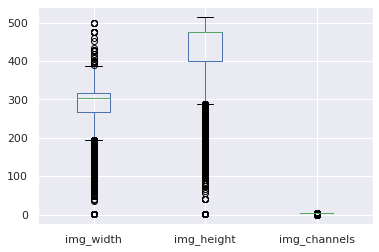

In [67]:
books_sample_df.boxplot(column = ['img_width', 'img_height', 'img_channels'])

In [70]:
print('Image mean width: ', books_sample_df['img_width'].mean())
print('Image mean height: ', books_sample_df['img_height'].mean())

Image mean width:  282.15171693432563
Image mean height:  425.5430212821517


In [83]:
books_sample_df['img_channels'].value_counts(dropna=False)

3    53131
0      330
4      152
Name: img_channels, dtype: int64

### Text

In [1]:
textDf = pd.read_csv(DF_PATH + 'book_data.csv')

NameError: name 'pd' is not defined

In [ ]:
textDf.head()

In [ ]:
dfDescription = textDf[['book_desc', 'book_rating']]

In [ ]:
dfDescription.head()

So some books have non English descriptions. Don't really know an easy way to drop those, so let's just hope most of them are in English.

In [229]:
dfDescription['book_desc'][0]

"Winning will make you famous. Losing means certain death.The nation of Panem, formed from a post-apocalyptic North America, is a country that consists of a wealthy Capitol region surrounded by 12 poorer districts. Early in its history, a rebellion led by a 13th district against the Capitol resulted in its destruction and the creation of an annual televised event known as the Hunger Games. In punishment, and as a reminder of the power and grace of the Capitol, each district must yield one boy and one girl between the ages of 12 and 18 through a lottery system to participate in the games. The 'tributes' are chosen during the annual Reaping and are forced to fight to the death, leaving only one survivor to claim victory.When 16-year-old Katniss's young sister, Prim, is selected as District 12's female representative, Katniss volunteers to take her place. She and her male counterpart Peeta, are pitted against bigger, stronger representatives, some of whom have trained for this their whole

In [230]:
dfDescription['book_desc'][100]

"Among the seminal texts of the 20th century, Nineteen Eighty-Four is a rare work that grows more haunting as its futuristic purgatory becomes more real. Published in 1949, the book offers political satirist George Orwell's nightmare vision of a totalitarian, bureaucratic world and one poor stiff's attempt to find individuality. The brilliance of the novel is Orwell's prescience of modern life--the ubiquity of television, the distortion of the language--and his ability to construct such a thorough version of hell. Required reading for students since it was published, it ranks among the most terrifying novels ever written."

In [231]:
# Check for books withouth desc
dfDescription['book_desc'].isna().sum()

1331

In [237]:
# drop those
dfDescription = dfDescription[dfDescription['book_desc'].notnull()].reset_index(drop=True)

In [232]:
len(dfDescription)

54301

In [233]:
word_count = [str(i).count(' ') for i in dfDescription['book_desc']]

In [234]:
max(word_count)

3581

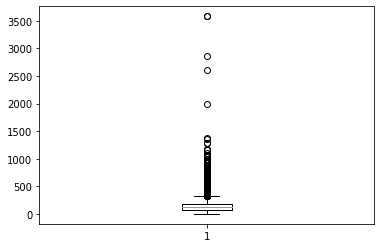

In [235]:
a = plt.boxplot(word_count)

In [236]:
print(np.mean(word_count))
print(np.median(word_count))

136.58054179481042
127.0


### Mean model for benchmarking

In [75]:
labels = books_sample_df[['img_name', 'book_rating']].set_index('img_name')
labels.head()

,book_rating
img_name,
0,4.33
1,4.48
2,4.27
3,4.25
4,3.58


In [80]:
valIndex = random.sample(range(len(labels)), round(len(labels)*VAL_SIZE))
trainIndex = [i for i in range(len(labels)) if i not in valIndex]

train = labels.iloc[trainIndex,]
validation = labels.iloc[valIndex,]

In [81]:
meanModel = train.book_rating.mean()
print(meanModel)

4.018635113079973


In [82]:
meanModel_valMSE = sum((validation.book_rating - meanModel)**2)/len(validation)
print(meanModel_valMSE)

0.11564349413951246
